# Data overview

by Vito Zanotelli <vito.zanotelli@gmail.com>

## Aim:
This should provides some quick visualization and data exploration over all variables in the openZH/covid19 data repository.


Note that I am NOT an epidemiologist and these visualizations these numbers and plots have plenty of caveats.

The analysis is kept as tidy as possible. Any feedback welcome!

Parts adapted from the 'visualise' notebook by Tim Head <betatim@gmail.com> licensed under CC-BY-4 (https://github.com/openZH/covid_19/blob/master/visualise.ipynb).

In [1]:
# visualization
import colorcet # colormaps
import plotnine as gg # a great ggplot clone

%matplotlib inline

In [2]:
# General
import pandas as pd
import numpy as np
import glob

In [3]:
import helpers.library as lib

In [4]:
class C:
    """
    Helper class to keep input configuration.
    """
    glob_cases = "data/covid/covid_19/fallzahlen_kanton_total_csv/COVID19_Fallzahlen_Kanton_*total.csv"
    
    
class V:
    """
    Helper class to keep metadata related variables.
    """
    # User columns
    COL_VARIABLES = 'variables'
    COL_VALUE = 'value'
    
    # Data columns: from the data description from https://github.com/openZH/covid_19
    COL_DATE = 'date'
    COL_CANTON = 'abbreviation_canton_and_fl'
    
    COL_CUM_CONFIRMED = 'ncumul_conf'
    COL_CUM_DECEASED = 'ncumul_deceased' # number of deaths
    COL_CUM_TESTED = 'ncumul_tested'
    
    COL_CUR_HOSP = 'ncumul_hosp'
    COL_CUR_ICU = 'ncumul_ICU'
    COL_CUR_VENT = 'ncumul_vent'
    
    COL_CUM_RELEASED = 'ncumul_released'
    COL_CUM_CURED = 'TotalCured'
    
    
    vars_labels = {COL_CUM_CONFIRMED: 'Total confirmed cases',
                  COL_CUR_HOSP: 'Current hospitalized cases',
                  COL_CUM_DECEASED: 'Total deceased cases',
                  COL_CUR_ICU: 'Current intensive care cases',
                  COL_CUR_VENT: 'Current ventilator cases',
                  COL_CUM_RELEASED: 'Total released from hospital',
                  COL_CUM_CURED: 'Total cured cases',
                  COL_CUM_TESTED: 'Total tested cases'
        
    }
    vars_all = vars_labels.keys()
    
    # My main variables of interest
    vars_main = [COL_CUM_CONFIRMED,
                     COL_CUM_DECEASED,
                     COL_CUR_HOSP]

Load data

In [5]:
tdats = map(pd.read_csv, glob.glob(C.glob_cases))
dat_total = pd.concat(tdats)

In [6]:
dat_total.columns

Index(['date', 'time', 'abbreviation_canton_and_fl', 'ncumul_tested',
       'ncumul_conf', 'ncumul_hosp', 'ncumul_ICU', 'ncumul_vent',
       'ncumul_released', 'ncumul_deceased', 'source', 'TotalPosTests1',
       'ninst_ICU_intub', 'ncumul_confirmed_non_resident',
       'ninst_hosp_non_resident', 'TotalCured', 'ncumul_ICF',
       'ncumul_deceased_suspect'],
      dtype='object')

In [7]:
dat_total.head()

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,ncumul_hosp,ncumul_ICU,ncumul_vent,ncumul_released,ncumul_deceased,source,TotalPosTests1,ninst_ICU_intub,ncumul_confirmed_non_resident,ninst_hosp_non_resident,TotalCured,ncumul_ICF,ncumul_deceased_suspect
0,2020-02-28,NaN,VD,NaN,NaN,4.0,NaN,NaN,NaN,NaN,https://www.vd.ch/toutes-les-actualites/hotlin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-29,NaN,VD,NaN,NaN,4.0,NaN,NaN,NaN,NaN,https://www.vd.ch/toutes-les-actualites/hotlin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-01,NaN,VD,NaN,NaN,4.0,NaN,NaN,NaN,NaN,https://www.vd.ch/toutes-les-actualites/hotlin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-02,NaN,VD,NaN,NaN,6.0,NaN,NaN,NaN,NaN,https://www.vd.ch/toutes-les-actualites/hotlin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-03,NaN,VD,NaN,NaN,8.0,NaN,NaN,NaN,NaN,https://www.vd.ch/toutes-les-actualites/hotlin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Start Visualizations



Parsing of metadata into the right classes

In [8]:
dat_total[V.COL_DATE] = pd.to_datetime(dat_total[V.COL_DATE], dayfirst=True)
dat_total[V.COL_CANTON] = pd.Categorical(dat_total[V.COL_CANTON])

Interpolate data to get daily values

In [9]:
dat_daily = lib.transform_daily_per_canton(dat_total, V.vars_all, col_canton=V.COL_CANTON, col_date=V.COL_DATE)

Plot the most interesting values over time

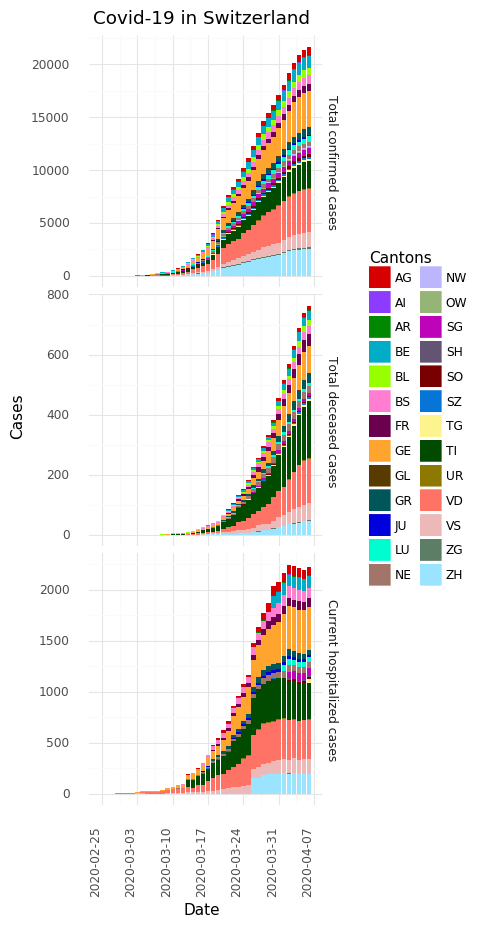

<ggplot: (8785286446926)>

In [10]:
cur_vars = V.vars_main

g = (dat_daily
     .melt(id_vars=[V.COL_DATE, V.COL_CANTON], value_vars=cur_vars,
           var_name=V.COL_VARIABLES,
          value_name=V.COL_VALUE)
     .assign(**{V.COL_VARIABLES:
                lambda x: pd.Categorical(x[V.COL_VARIABLES],
                                         categories=cur_vars)
                          .rename_categories(V.vars_labels)})
    
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}', y=V.COL_VALUE, fill=V.COL_CANTON))
     + gg.facet_grid(f'{V.COL_VARIABLES}~.', scales='free_y')
     + gg.geom_bar(stat='identity')
     + gg.scale_fill_manual(colorcet.glasbey, name='Cantons')
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.xlab('Date')
     + gg.ylab('Cases')
     + gg.ggtitle('Covid-19 in Switzerland')
     + gg.theme_minimal()
     + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(3,10)
               )
 
 
)
g

Things to improve:
- Sort cantons according to the total incidence instead of alphabetically


In [11]:
cord = (dat_daily
    .groupby(V.COL_CANTON)
    [V.COL_CUM_DECEASED].mean()
    .sort_values(ascending=False)
    .index
)
cat_cantons_deceased= pd.CategoricalDtype(cord.astype(str), ordered=True)

Sorted cantons

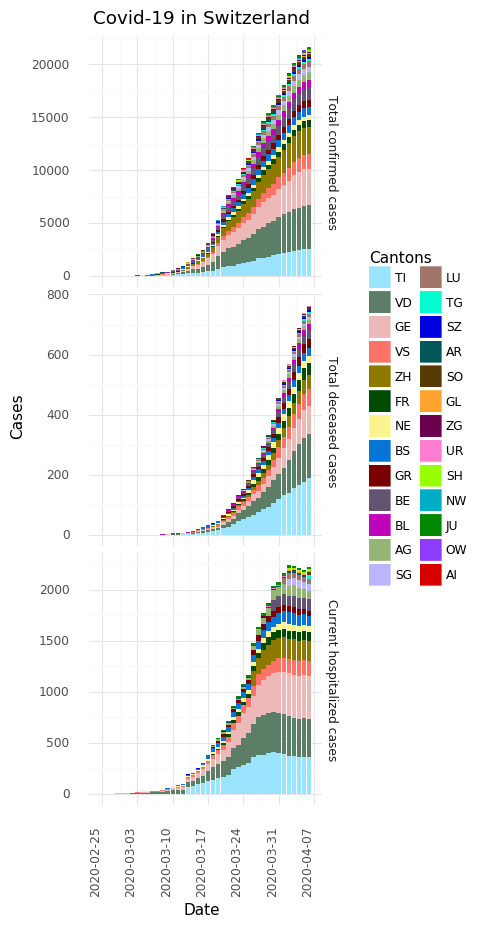

<ggplot: (-9223363251664845052)>

In [12]:
cur_vars = V.vars_main

g = (dat_daily
     .melt(id_vars=[V.COL_DATE, V.COL_CANTON], value_vars=cur_vars,
           var_name=V.COL_VARIABLES,
          value_name=V.COL_VALUE)
     .assign(**{V.COL_VARIABLES:
                lambda x: pd.Categorical(x[V.COL_VARIABLES],
                                         categories=cur_vars)
                          .rename_categories(V.vars_labels)})
         .assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=True)})
    
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}', y=V.COL_VALUE, fill=V.COL_CANTON))
     + gg.facet_grid(f'{V.COL_VARIABLES}~.', scales='free_y')
     + gg.geom_bar(stat='identity')
     + gg.scale_fill_manual(colorcet.glasbey, name='Cantons',
                            guide = gg.guide_legend(reverse = True))
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.xlab('Date')
     + gg.ylab('Cases')
     + gg.ggtitle('Covid-19 in Switzerland')
     + gg.theme_minimal()
     + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(3,10)
               )
 
 
)
g

Also plot all the variables - this might be informative but also wil be quite messy

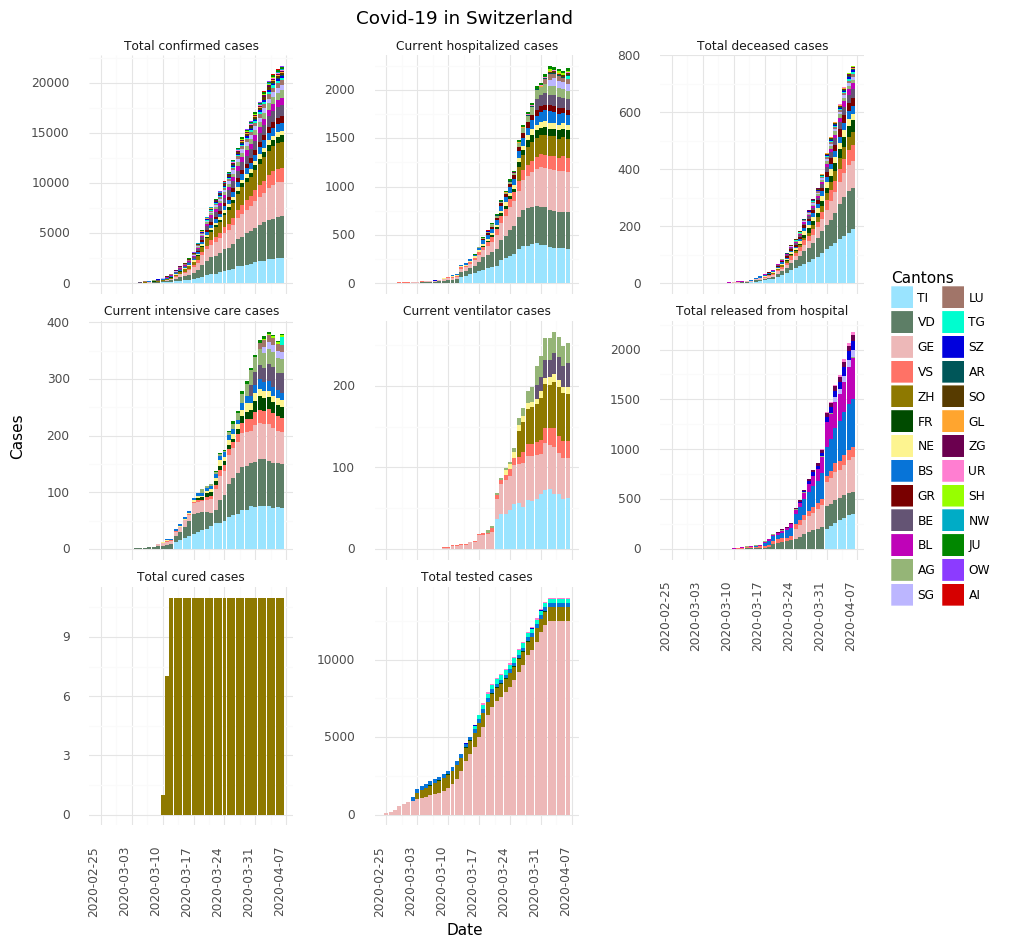

<ggplot: (-9223363251665295907)>

In [13]:
cur_vars = V.vars_all

g = (dat_daily
     .melt(id_vars=[V.COL_DATE, V.COL_CANTON], value_vars=cur_vars,
           var_name=V.COL_VARIABLES,
          value_name=V.COL_VALUE)
     .assign(**{V.COL_VARIABLES:
                lambda x: pd.Categorical(x[V.COL_VARIABLES],
                                         categories=cur_vars)
                          .rename_categories(V.vars_labels)})
         .assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=True)})
    
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}', y=V.COL_VALUE, fill=V.COL_CANTON))
     + gg.facet_wrap(f'{V.COL_VARIABLES}', scales='free_y')
     + gg.geom_bar(stat='identity')
     + gg.scale_fill_manual(colorcet.glasbey, name='Cantons',
                            guide = gg.guide_legend(reverse = True))
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.xlab('Date')
     + gg.ylab('Cases')
     + gg.ggtitle('Covid-19 in Switzerland')
     + gg.theme_minimal()
     + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(10,10),
                subplots_adjust={'wspace': 0.4})
 
 
)
g

While this gives quite a good overview, it might be interesting to visualize these per canton, so per canton trends are better visible:

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


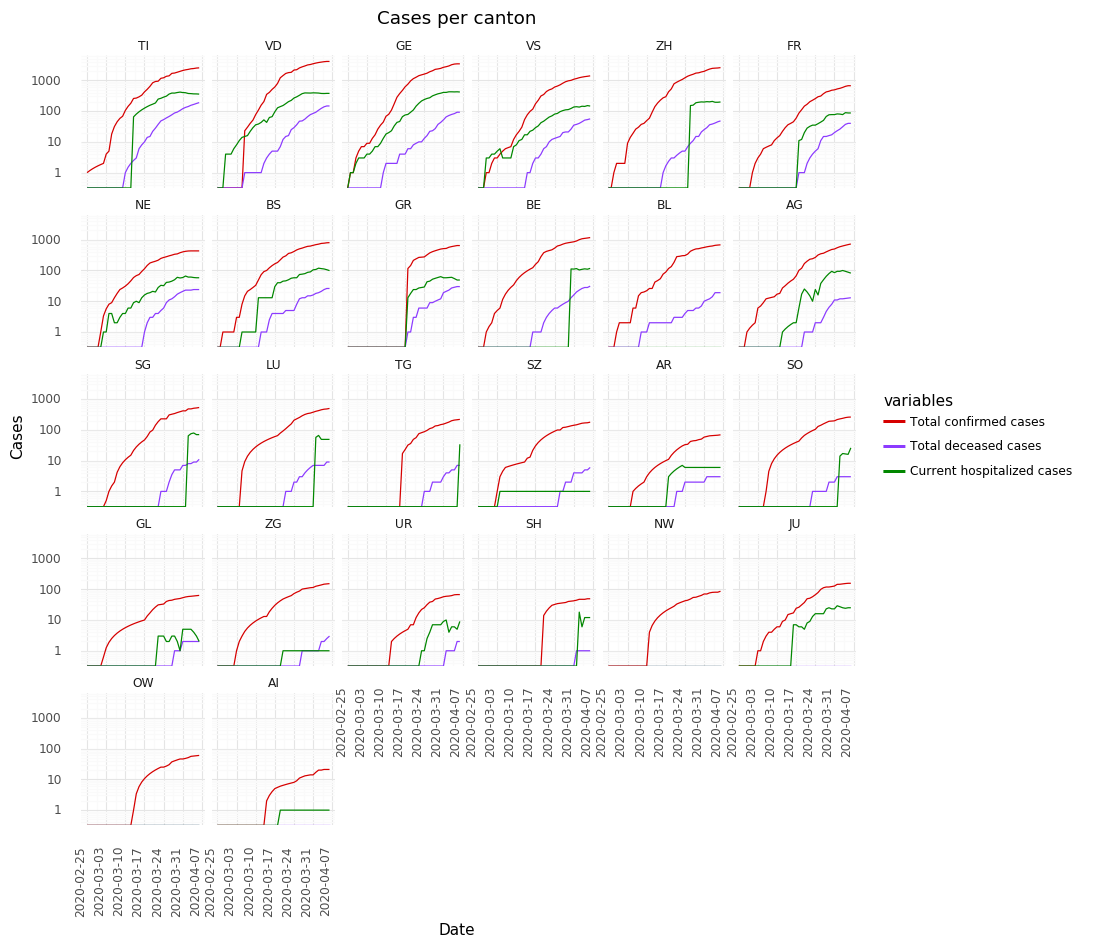

<ggplot: (8785188138970)>

In [14]:
cur_vars = V.vars_main
g = (dat_daily
     .melt(id_vars=[V.COL_DATE, V.COL_CANTON], value_vars=cur_vars,
           var_name=V.COL_VARIABLES,
          value_name=V.COL_VALUE)
     .assign(**{V.COL_VARIABLES:
                lambda x: pd.Categorical(x[V.COL_VARIABLES],
                                         categories=cur_vars)
                          .rename_categories(V.vars_labels)})
         .assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=False)})
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}',
                      y=V.COL_VALUE,
                      color=V.COL_VARIABLES))
     + gg.facet_wrap(f'{V.COL_CANTON}')
     + gg.geom_line(stat='identity')
     + gg.scale_color_manual(colorcet.glasbey)
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.scale_y_log10()
     + gg.xlab('Date')
     + gg.ylab('Cases')
     + gg.ggtitle('Cases per canton')
     + gg.theme_minimal()
     + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(10,10))
 
)
g

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

  warn(_TPL_DUPLICATE_SCALE.format(ae), PlotnineWarning)


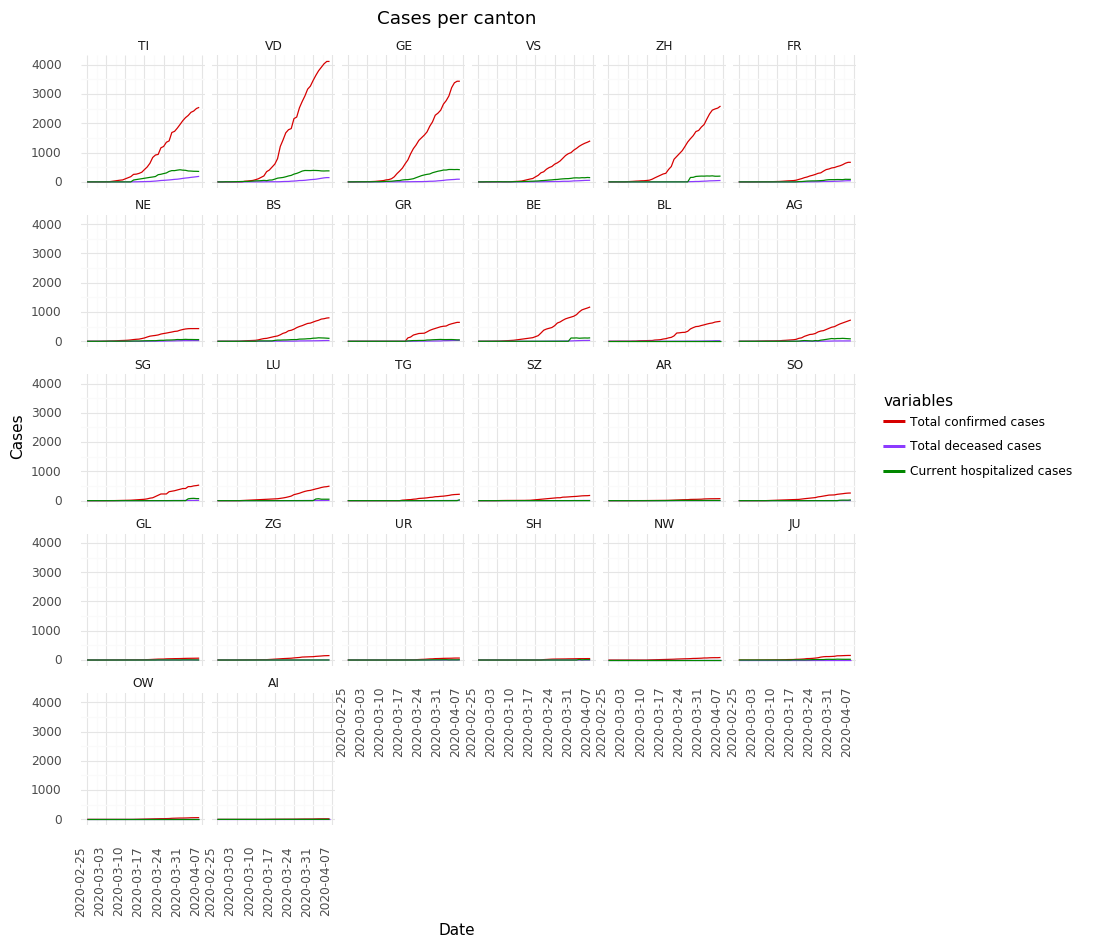

<ggplot: (8785286479466)>

In [15]:
# also once with linear scale
g + gg.scale_y_continuous()

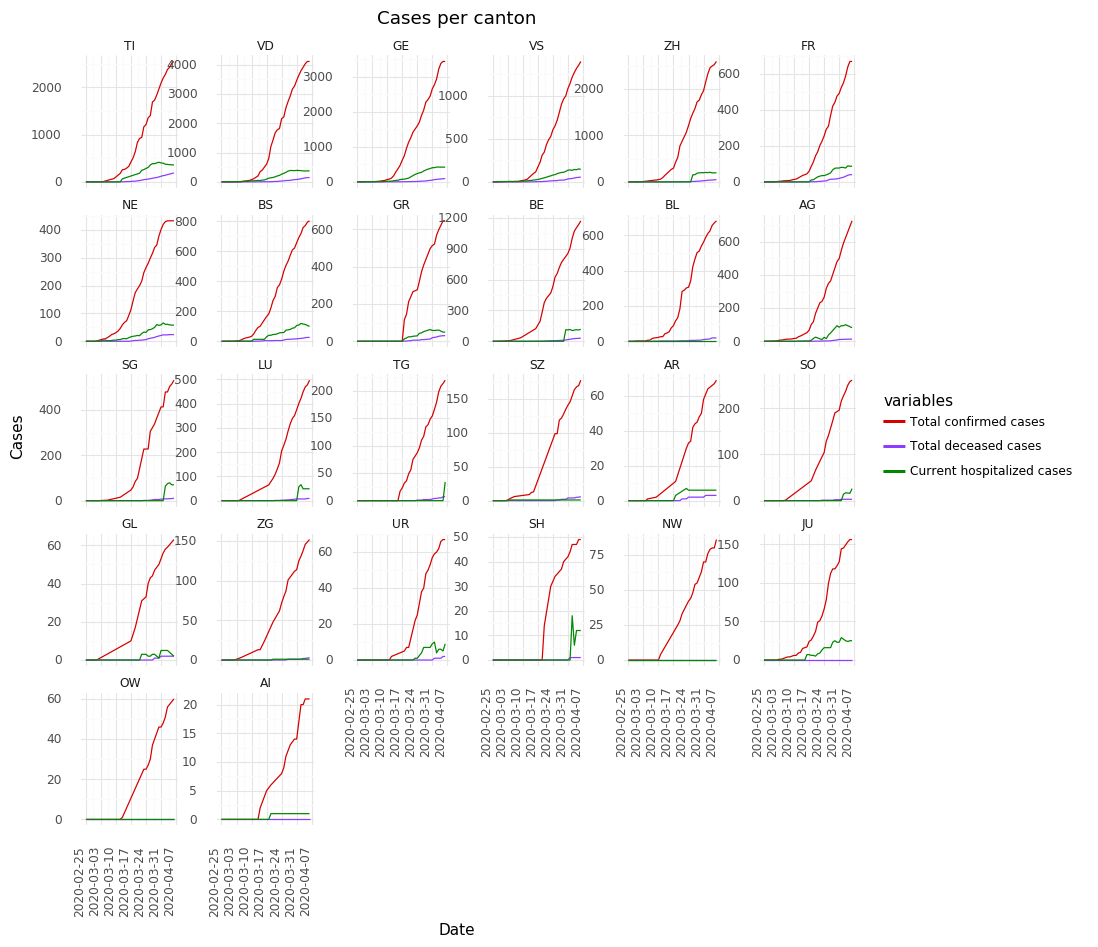

<ggplot: (8785186113270)>

In [16]:
# linear scale but with individual scaling

cur_vars = V.vars_main

g = (dat_daily
     .melt(id_vars=[V.COL_DATE, V.COL_CANTON], value_vars=cur_vars,
           var_name=V.COL_VARIABLES,
          value_name=V.COL_VALUE)
     .assign(**{V.COL_VARIABLES:
                lambda x: pd.Categorical(x[V.COL_VARIABLES],
                                         categories=cur_vars)
                          .rename_categories(V.vars_labels)})
         .assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=False)})
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}',
                      y=V.COL_VALUE,
                      color=V.COL_VARIABLES))
     + gg.facet_wrap(f'{V.COL_CANTON}', scales='free_y')
     + gg.geom_line(stat='identity')
     + gg.scale_color_manual(colorcet.glasbey)
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.xlab('Date')
     + gg.ylab('Cases')
     + gg.ggtitle('Cases per canton')
     + gg.theme_minimal()
     + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(10,10),
                subplots_adjust={'wspace': 0.4})
 
)
g

Plot each variable individually + overlay original data points

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  PlotnineWarning)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 292 rows containing missing values.
  self.data = self.geom.handl

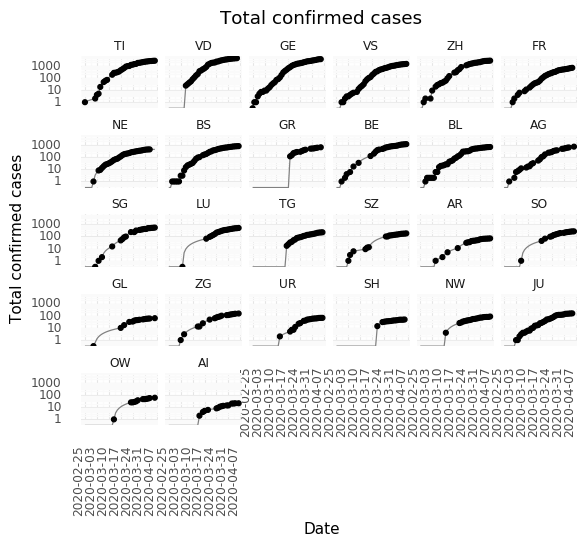

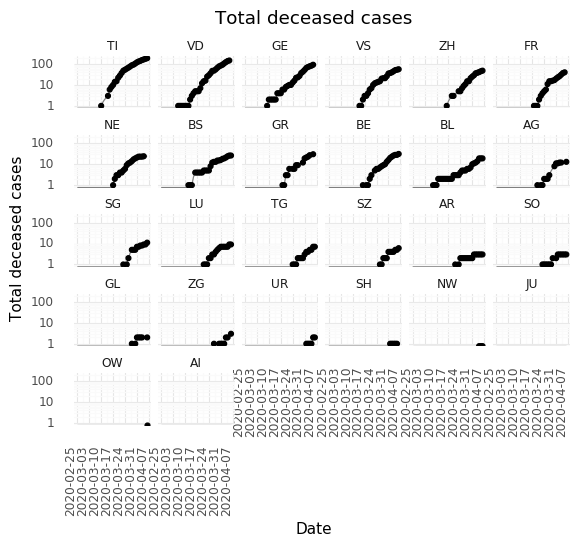

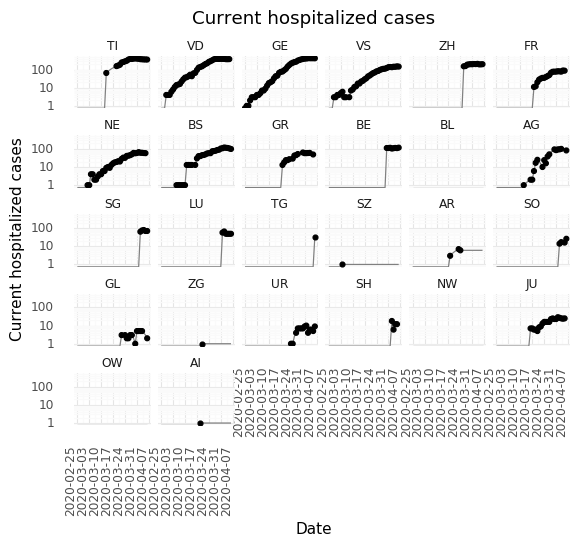

In [17]:
g = (dat_daily
    .assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=False)})
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}'))
     + gg.facet_wrap(f'{V.COL_CANTON}')
     + gg.scale_fill_manual(colorcet.glasbey)
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.scale_y_log10()
     + gg.xlab('Date')
     + gg.theme_minimal()
     +gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1))
 
)
    
dt = (dat_total.assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=False)}))
for var in V.vars_main:
    (g + gg.geom_line(gg.aes(y=var), color='grey')
     + gg.geom_point(gg.aes(y=var), data=dt, color='black')
     + gg.ylab(V.vars_labels[var])
        + gg.ggtitle(V.vars_labels[var])).draw() 

Also once for all parameters:

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


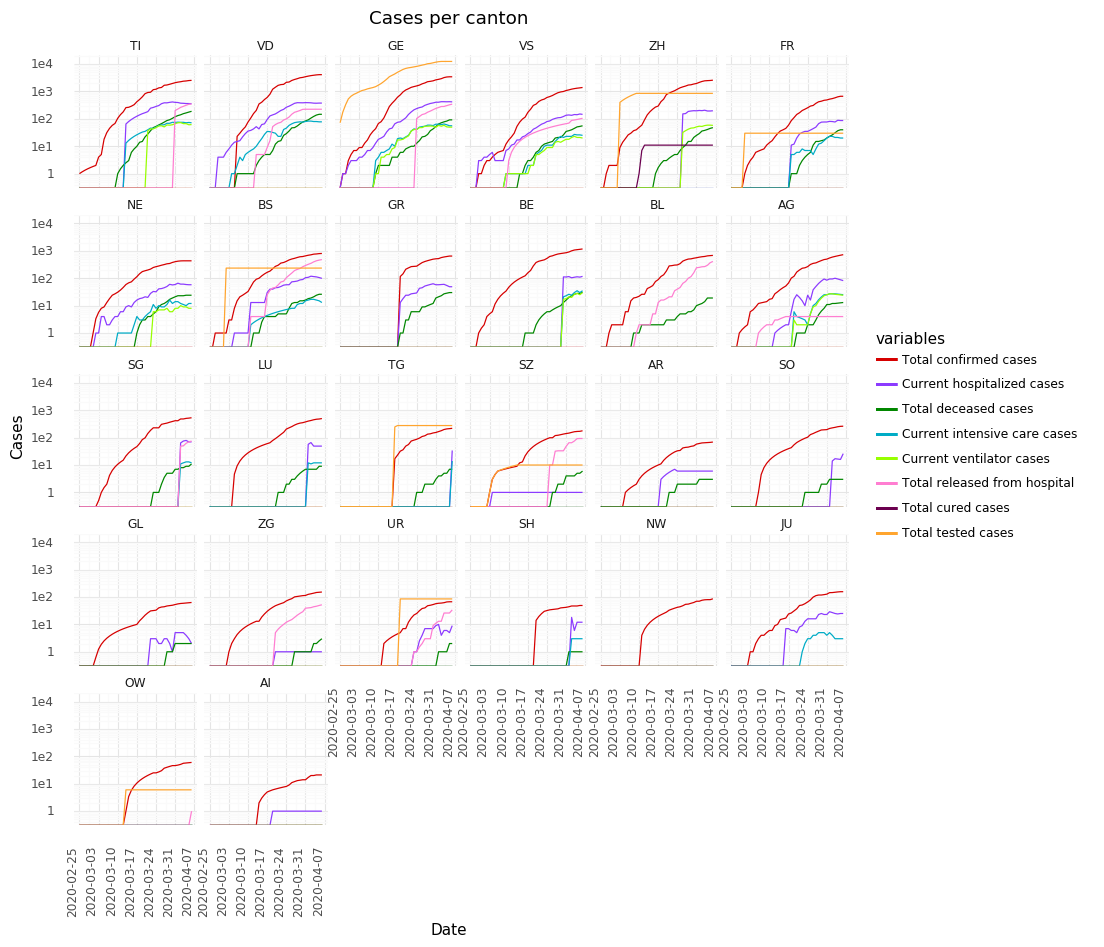

<ggplot: (8785185207111)>

In [18]:
cur_vars = V.vars_all
g = (dat_daily
     .melt(id_vars=[V.COL_DATE, V.COL_CANTON], value_vars=cur_vars,
           var_name=V.COL_VARIABLES,
          value_name=V.COL_VALUE)
     .assign(**{V.COL_VARIABLES:
                lambda x: pd.Categorical(x[V.COL_VARIABLES],
                                         categories=cur_vars)
                          .rename_categories(V.vars_labels)})
         .assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=False)})
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}',
                      y=V.COL_VALUE,
                      color=V.COL_VARIABLES))
     + gg.facet_wrap(f'{V.COL_CANTON}')
     + gg.geom_line(stat='identity')
     + gg.scale_color_manual(colorcet.glasbey)
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.scale_y_log10()
     + gg.xlab('Date')
     + gg.ylab('Cases')
     + gg.ggtitle('Cases per canton')
     + gg.theme_minimal()
     + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(10,10))
 
)
g

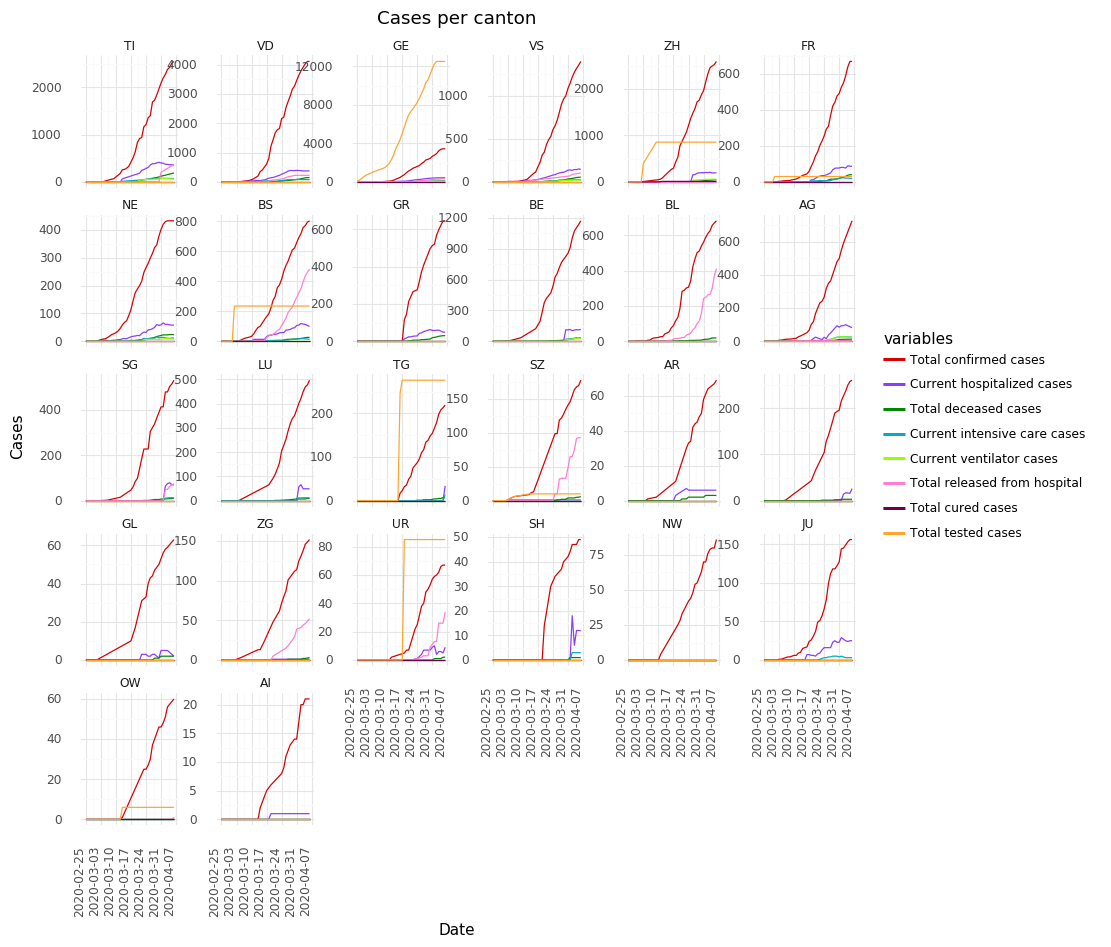

<ggplot: (8785185197071)>

In [19]:
# linear scale but with individual scaling

cur_vars = V.vars_all

g = (dat_daily
     .melt(id_vars=[V.COL_DATE, V.COL_CANTON], value_vars=cur_vars,
           var_name=V.COL_VARIABLES,
          value_name=V.COL_VALUE)
     .assign(**{V.COL_VARIABLES:
                lambda x: pd.Categorical(x[V.COL_VARIABLES],
                                         categories=cur_vars)
                          .rename_categories(V.vars_labels)})
         .assign(**{V.COL_CANTON: lambda x: lib.order_cat(x[V.COL_CANTON],cat_cantons_deceased,
                                                 rev=False)})
     >>
     gg.ggplot(gg.aes(x=f'{V.COL_DATE}',
                      y=V.COL_VALUE,
                      color=V.COL_VARIABLES))
     + gg.facet_wrap(f'{V.COL_CANTON}', scales='free_y')
     + gg.geom_line(stat='identity')
     + gg.scale_color_manual(colorcet.glasbey)
     + gg.scale_x_datetime(date_breaks='1 week')
     + gg.xlab('Date')
     + gg.ylab('Cases')
     + gg.ggtitle('Cases per canton')
     + gg.theme_minimal()
     + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(10,10),
                subplots_adjust={'wspace': 0.4})
 
)
g

Where to go from here:
- Correlating data with canton population size
- Mapping on Swiss map
- Spatio-temporal analysis with R-inla?

My conda environment

In [20]:
import sys
!conda env export -p {sys.prefix}

name: null
channels:
  - r
  - bioconda
  - pyviz
  - conda-forge
  - defaults
dependencies:
  - _libgcc_mutex=0.1=main
  - _r-mutex=1.0.0=mro_2
  - attrs=19.3.0=py_0
  - backcall=0.1.0=py_0
  - binutils_impl_linux-64=2.31.1=h6176602_1
  - binutils_linux-64=2.31.1=h6176602_8
  - blas=2.14=openblas
  - bleach=1.4.2=py36_0
  - boost-cpp=1.70.0=ha2d47e9_1
  - branca=0.4.0=py_0
  - bzip2=1.0.8=h516909a_2
  - ca-certificates=2019.11.28=hecc5488_0
  - cairo=1.14.12=h8948797_3
  - certifi=2019.11.28=py36h9f0ad1d_1
  - cffi=1.14.0=py36hd463f26_0
  - cfitsio=3.470=hb60a0a2_2
  - chardet=3.0.4=py36h9f0ad1d_1006
  - click=7.1.1=pyh8c360ce_0
  - click-plugins=1.1.1=py_0
  - cligj=0.5.0=py_0
  - colorcet=2.0.2=py_0
  - cryptography=2.8=py36h45558ae_2
  - curl=7.65.3=hbc83047_0
  - cycler=0.10.0=py_2
  - dbus=1.13.12=h746ee38_0
  - decorator=4.4.2=py_0
  - defusedxml=0.6.0=py_0
  - descartes=1.1.0=py_4
  - entrypoints=0.3=py36h9f0ad1d_1001
  - expat=2.2.9=he1b5a44_2
  - fiona=1.8.13=py36h900e953_0
 